Итак, здесь вы начинаете работу над своим небольшим проектом. Напоминаем — работать нужно с данными по ВВП Ганы. Выполняйте все задания проекта в одном Jupyter-ноутбуке.

In [1]:
from typing import Callable
from warnings import filterwarnings

import jupyter_black
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from arch import arch_model
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from grid_search_arima import GridSearch

In [2]:
filterwarnings("ignore")

In [3]:
jupyter_black.load(lab=False, line_length=79)

In [4]:
%matplotlib inline

In [5]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

# Статистические модели прогнозирования

In [6]:
df = pd.read_csv("ghana_gdp.csv", parse_dates=["year"], index_col="year")

In [7]:
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [8]:
df.tail()

,GDP (current US$)
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


In [9]:
df.size

62

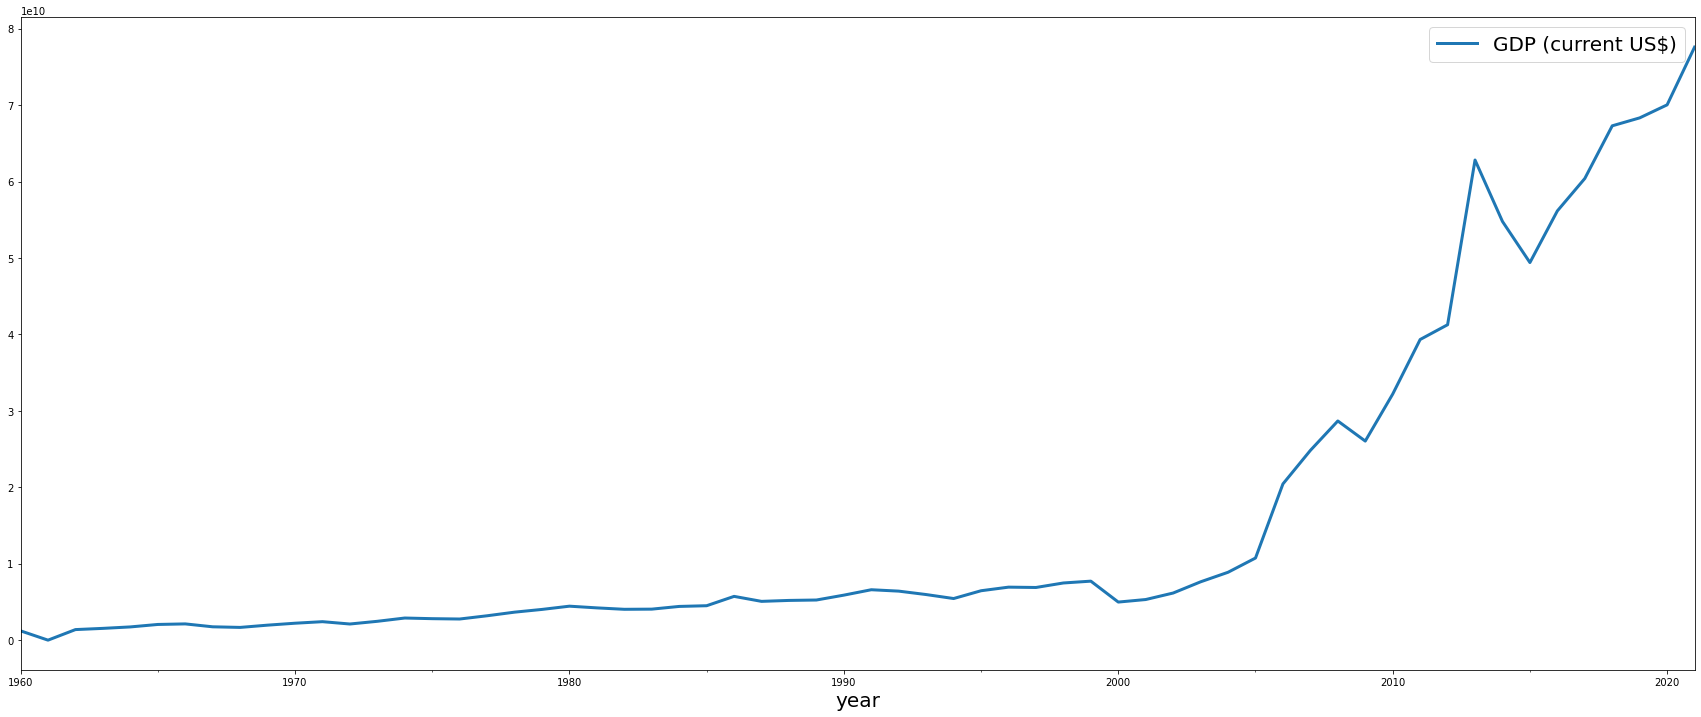

In [10]:
df.plot()
plt.show()

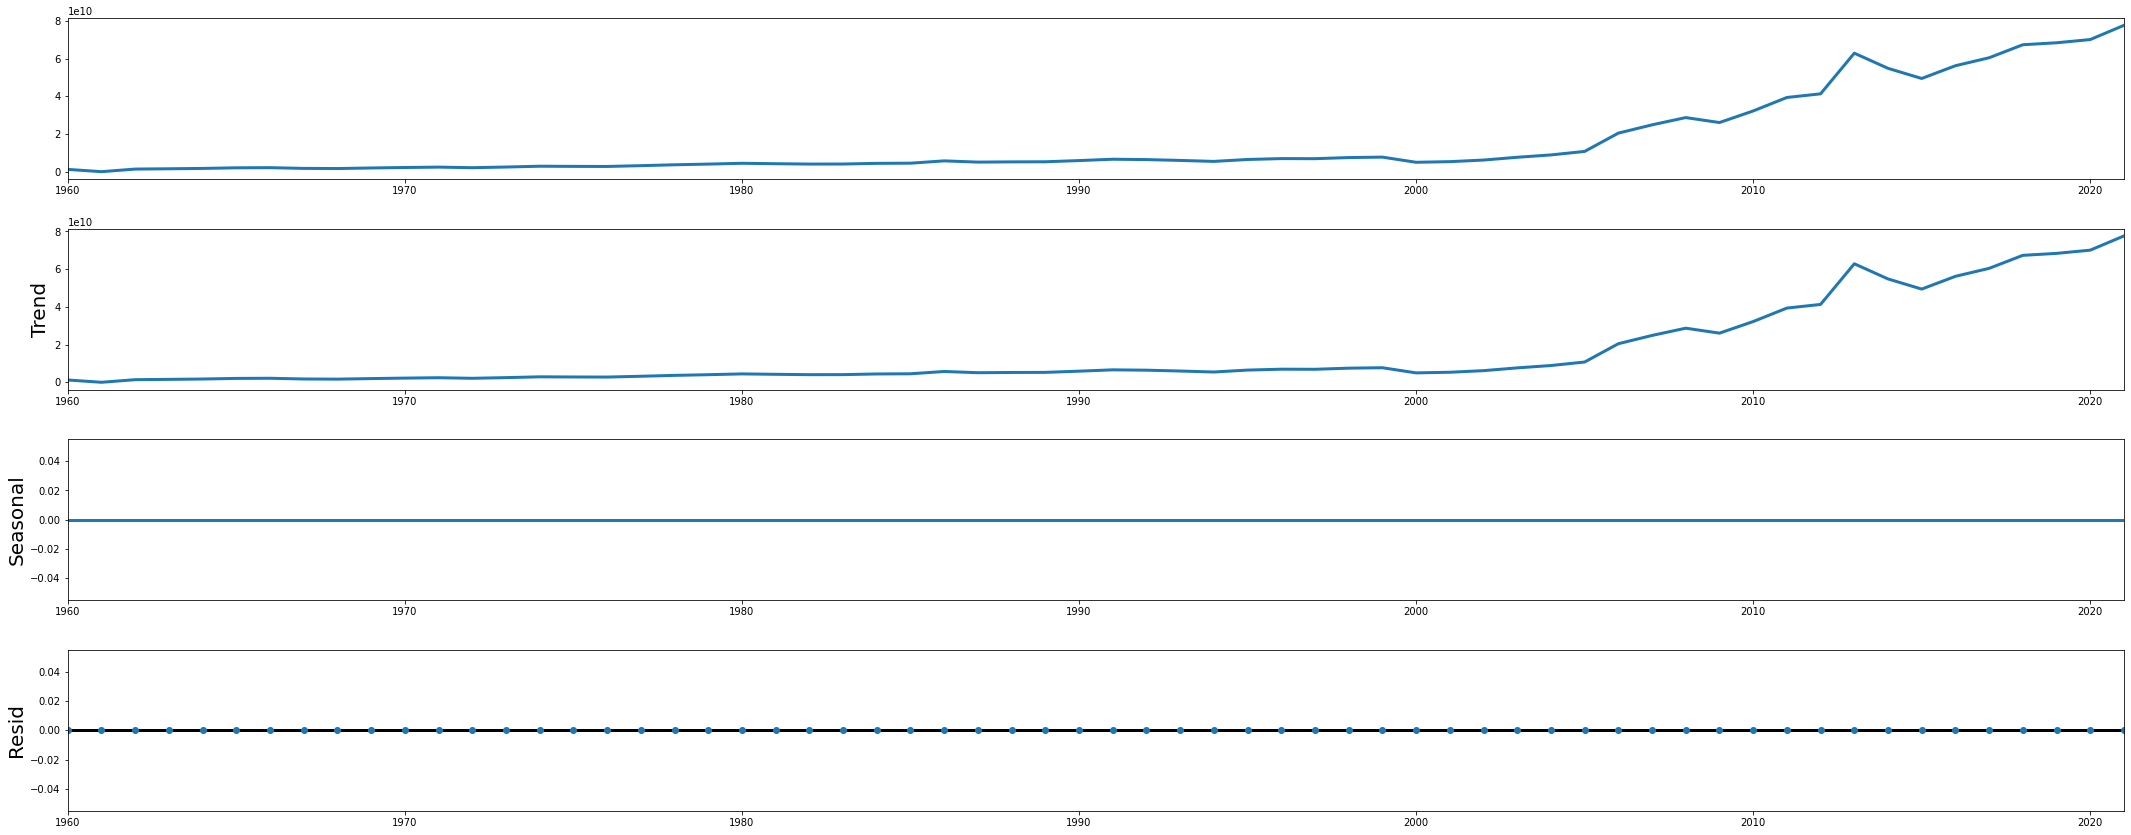

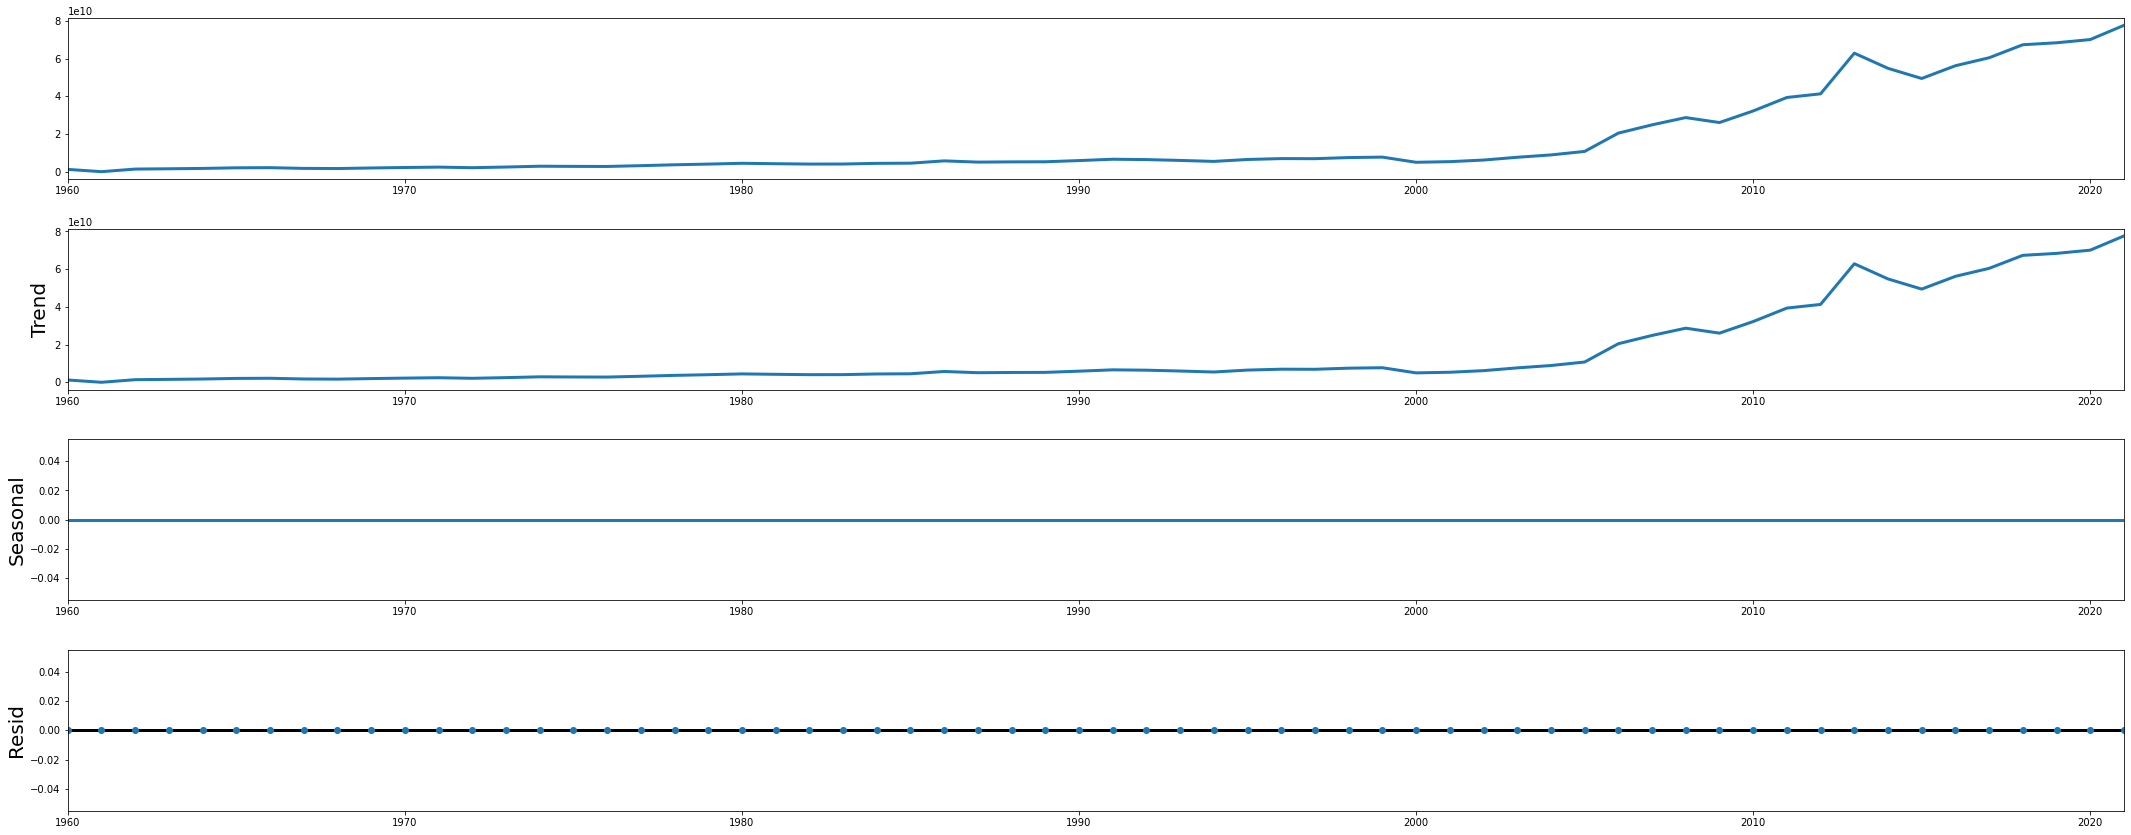

In [11]:
seasonal_decompose(df, model="additive").plot()

Отложите последние три года датасета как тестовую выборку для оценки результатов предсказания.

In [12]:
df_train = df.iloc[:-3]
df_test = df.iloc[-3:]

Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

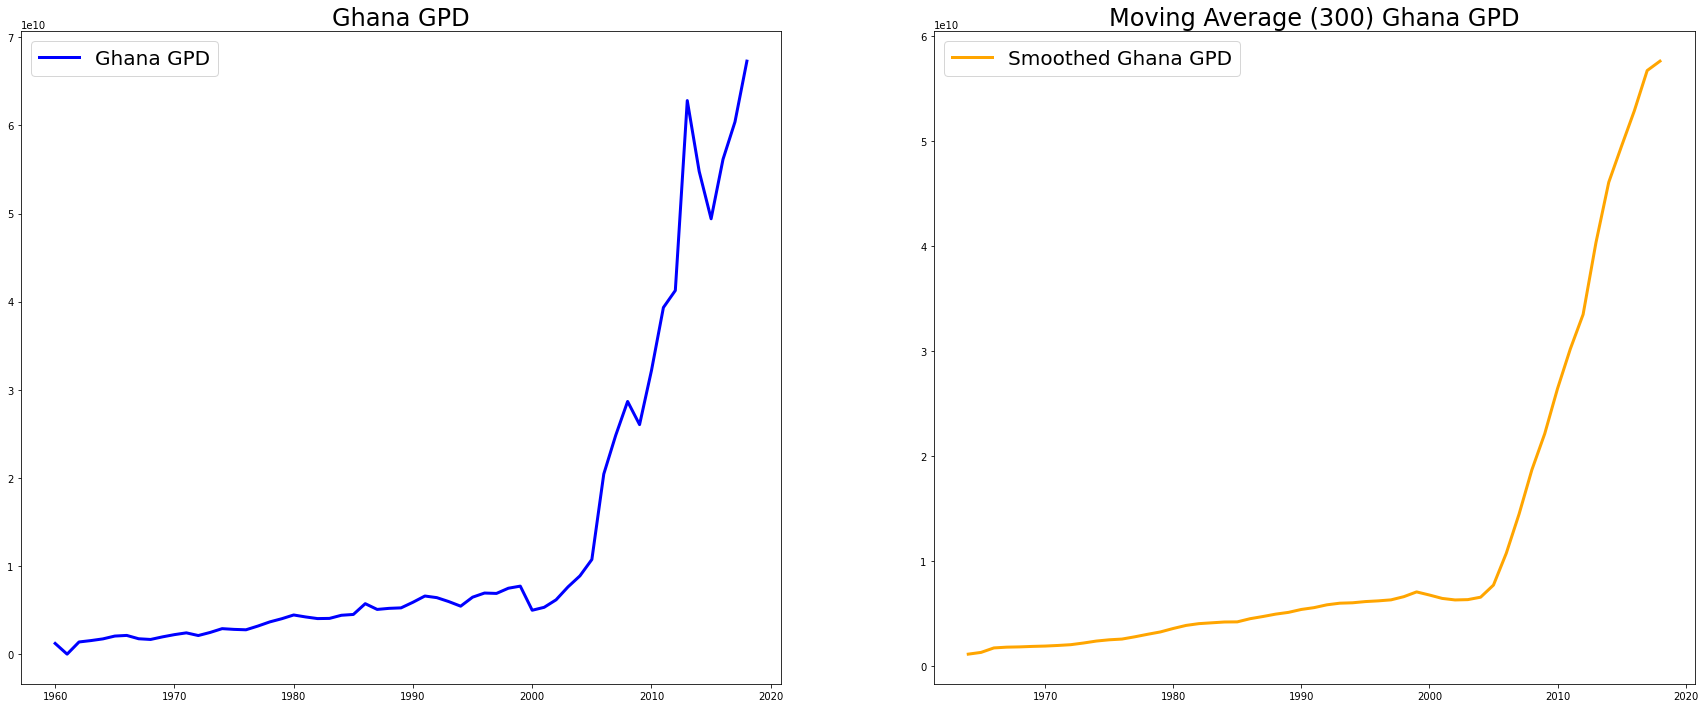

In [13]:
fig, ax = plt.subplots(1, 2)

# Окно в 5 лет (Window = 5)
ax[0].plot(df_train["GDP (current US$)"], color="blue", label="Ghana GPD")
ax[0].set_title("Ghana GPD", size=24)
ax[0].legend()

ax[1].plot(
    df_train["GDP (current US$)"].rolling(window=5).mean(),
    color="orange",
    label="Smoothed Ghana GPD",
)
ax[1].set_title("Moving Average (300) Ghana GPD", size=24)
ax[1].legend()

plt.show()

Оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA. Выберите парамeтры p и q по коррелограммам ACF и PACF. Также постройте модель с параметрами, ближайшими к p и q, и сравните коэффициент AIC или подберите наилучшие параметры с помощью pmdarima, как в скринкасте.

In [14]:
def is_stationary(series: pd.Series) -> bool:
    """
    Определяет, является ли ряд стационарным.

    Args:
        series: временной ряд

    Returns:
        True, если ряд является стационарным, иначе False
    """
    test = adfuller(series.dropna())
    print("adf: ", test[0])
    print("p-value: ", test[1])
    print("Critical values: ", test[4])
    return test[0] <= test[4]["5%"]

In [15]:
is_stationary(df_train["GDP (current US$)"])

adf:  0.6529066974885412
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


False

Ряд нестационарный, поэтому нам нужна модель ARIMA.

In [16]:
is_stationary(df_train["GDP (current US$)"].diff())

adf:  -1.67024830383208
p-value:  0.446502932971388
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


False

In [17]:
is_stationary(df_train["GDP (current US$)"].diff(2))

adf:  -3.583670865826034
p-value:  0.0060809897538768466
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}


True

Первые разности нестационарны, но вторые - стационарны. Тогда d = 2.

In [18]:
d = 2

In [19]:
def plot_correlogram(
    series: pd.Series, plot_function: Callable, ax: matplotlib.axes.Axes
) -> None:
    """
    Строит коррелограмму acf или pacf для временного ряда.

    Args:
        series: временной ряд
        corr_function: функция построения коррелограммы
        ax: оси, на которых нужно построить коррелограмму

    Raises:
        ValueError, если функция построения коррелограммы неправильная
    """
    lags = len(series) // 4

    if plot_function.__name__ == "plot_acf":
        plot_function(series, lags=lags, ax=ax)
    elif plot_function.__name__ == "plot_pacf":
        plot_function(series, lags=lags, ax=ax, method="ywm")
    else:
        raise ValueError("Incorrect plot function")

    ax.xaxis.set_ticks(np.arange(0, lags + 1, 1))
    ax.yaxis.set_ticks(np.arange(-1.0, 1.0, 0.1))
    ax.grid()

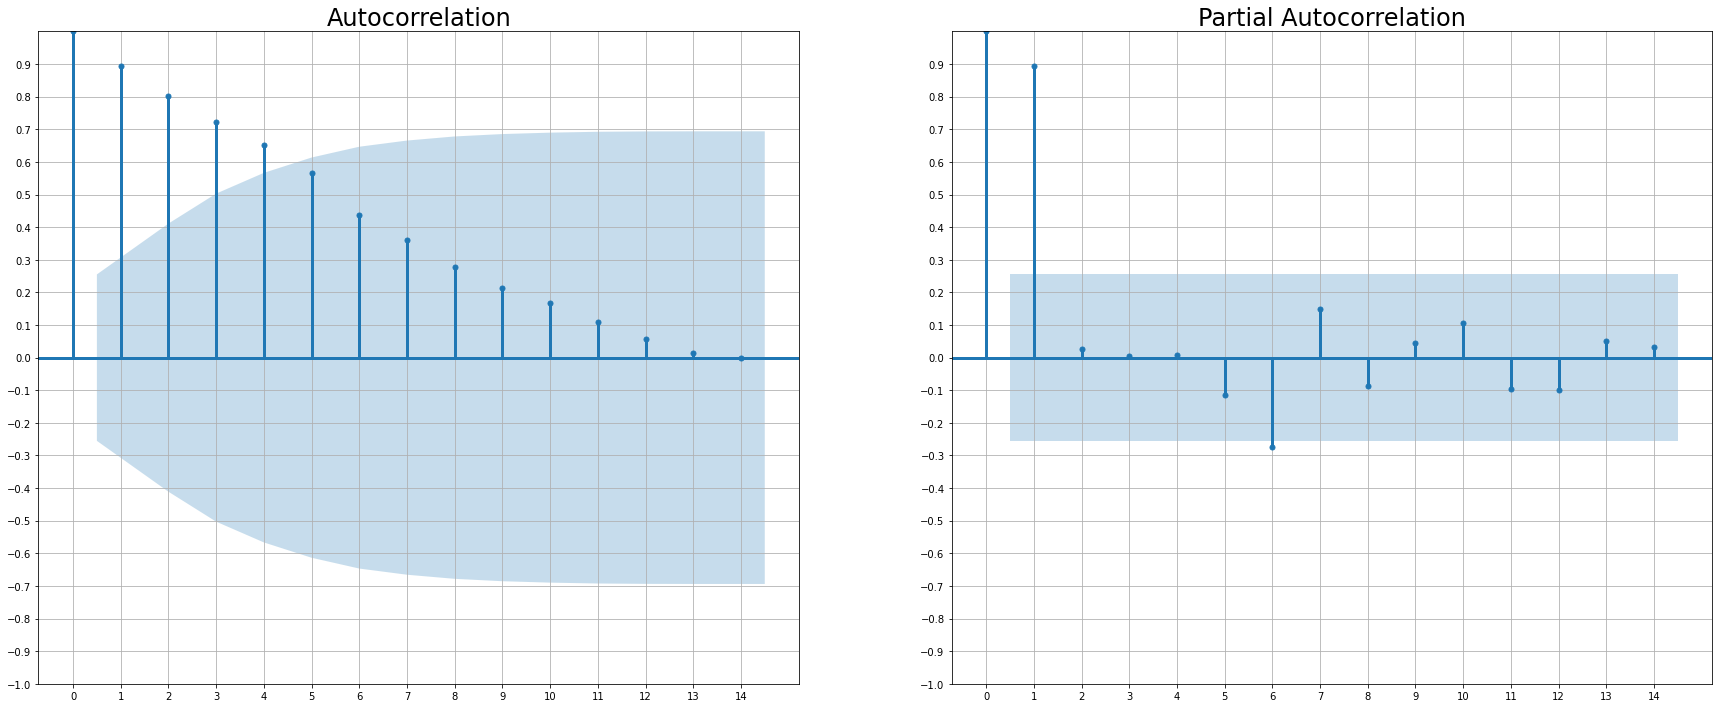

In [20]:
fig, ax = plt.subplots(1, 2)
plot_correlogram(df_train["GDP (current US$)"], plot_acf, ax[0])
plot_correlogram(df_train["GDP (current US$)"], plot_pacf, ax[1])
plt.show()

Как мы видим из графиков, оптимальное значение параметра *p* – 2, а *q* – 1.

Подберём наилучшие значения параметров вручную по сетке.

In [21]:
param_grid = {
    "p": range(1, 3),
    "q": range(1, 3),
}

In [22]:
grid_search = GridSearch(ARIMA, param_grid)

In [23]:
grid_search.fit(df_train["GDP (current US$)"], d=d)

4it [00:00,  7.47it/s]


In [24]:
print(grid_search.results_)

{'param_p': [1, 1, 2, 2], 'param_q': [1, 2, 1, 2], 'score': [2684.415773283554, 2680.987629981022, 2683.781799429223, 2675.9721300328897], 'params': [{'p': 1, 'q': 1, 'd': 2}, {'p': 1, 'q': 2, 'd': 2}, {'p': 2, 'q': 1, 'd': 2}, {'p': 2, 'q': 2, 'd': 2}]}


In [25]:
grid_search.best_score_

2675.9721300328897

In [26]:
grid_search.best_params_

(2, 2, 2)

In [27]:
print(grid_search.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1332.986
Date:                Thu, 26 Jan 2023   AIC                           2675.972
Time:                        22:52:19   BIC                           2686.187
Sample:                    01-01-1960   HQIC                          2679.942
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0516      0.067    -15.749      0.000      -1.182      -0.921
ar.L2         -0.3640      0.091     -4.016      0.000      -0.542      -0.186
ma.L1          0.1476      0.112      1.318      0.1

Постройте модель с наилучшими параметрами и выполните предсказание на три года.

In [28]:
df_pred = pd.concat(
    [
        df["GDP (current US$)"],
        grid_search.predict(df),
        grid_search.get_forecast(df_test["GDP (current US$)"]).conf_int(
            alpha=0.05
        ),
    ],
    axis=1,
)

In [29]:
df_pred

,GDP (current US$),predicted_mean,lower GDP (current US$),upper GDP (current US$)
1960-01-01,1.217087e+09,0.000000e+00,NaN,NaN
1961-01-01,0.000000e+00,1.798290e+09,NaN,NaN
1962-01-01,1.382353e+09,8.493134e+07,NaN,NaN
1963-01-01,1.540616e+09,1.910521e+09,NaN,NaN
1964-01-01,1.731092e+09,1.185761e+09,NaN,NaN
...,...,...,...,...
2017-01-01,6.040638e+10,5.453490e+10,NaN,NaN
2018-01-01,6.729928e+10,6.641404e+10,NaN,NaN
2019-01-01,6.833754e+10,6.751437e+10,6.090316e+10,7.412557e+10
2020-01-01,7.004320e+10,7.304425e+10,6.331091e+10,8.277760e+10


Отобразите результат графически.

In [30]:
def plot_forecast(df: pd.DataFrame, full: bool = True) -> None:
    """
    Строит график прогноза модели для временного ряда.

    Args:
        df: датафрейм с предсказаниями
        full: если False, то график строится только для тестовой выборки
    """
    if full:
        plt.plot(df.loc[df_train.index].iloc[:, 0], color="blue")
        plt.plot(
            df.loc[df_train.index].iloc[:, 1],
            color="orange",
            label="Predictions (train)",
        )

    plt.plot(
        df.loc[df_test.index].iloc[:, 1],
        color="red",
        label="Predictions (test)",
    )

    plt.plot(df.loc[df_test.index].iloc[:, 0], color="blue", label="Actuals")

    if df.shape[1] == 4:
        plt.plot(
            df.iloc[:, 2].dropna(),
            color="green",
            linestyle="--",
            label="Confidence Intervals (95%)",
        )
        plt.plot(
            df.iloc[:, 3].dropna(),
            color="green",
            linestyle="--",
        )

    plt.legend()

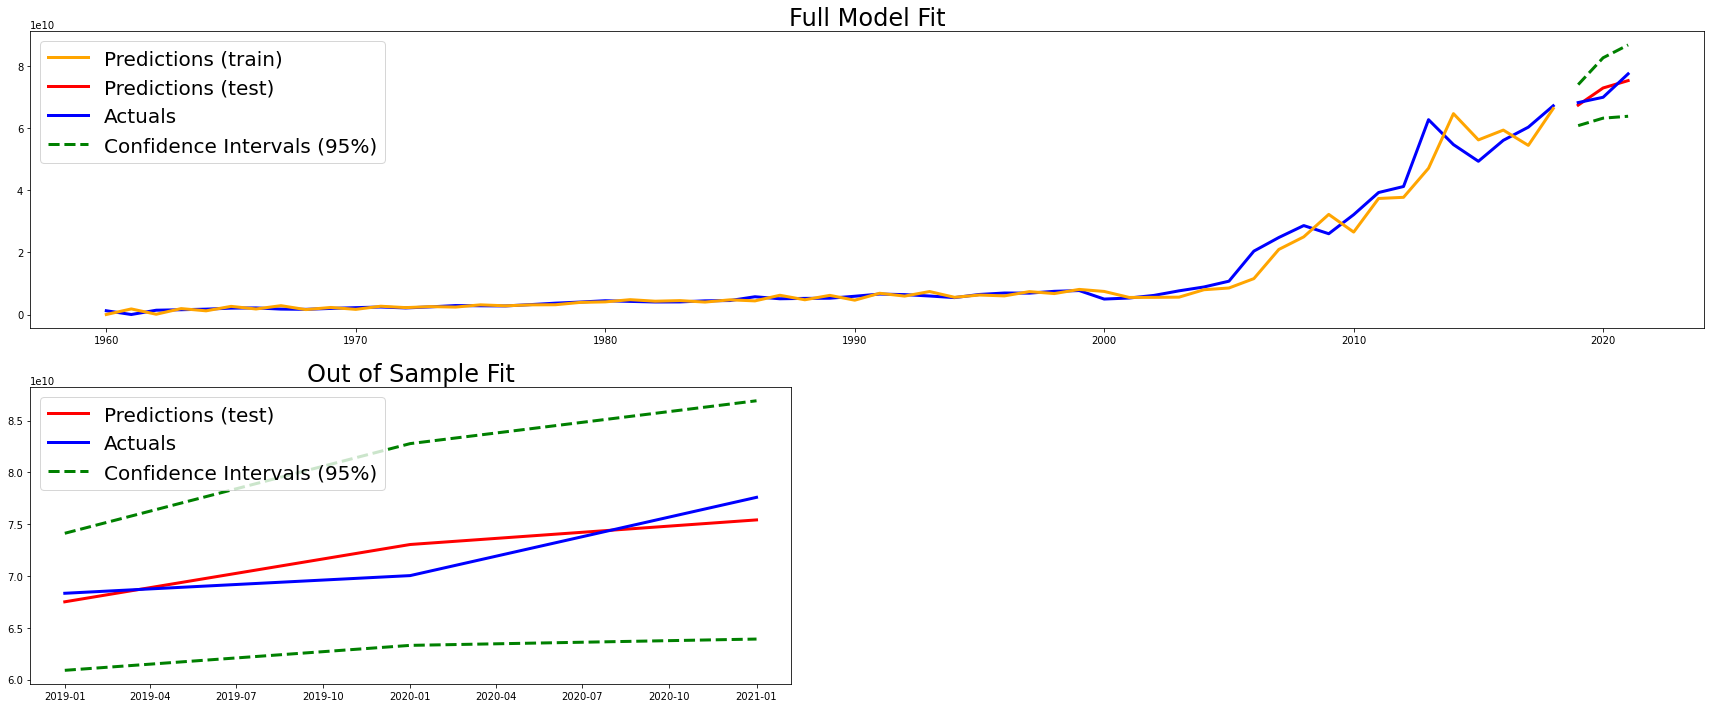

In [31]:
plt.subplot(2, 1, 1)
plot_forecast(df_pred)
plt.title("Full Model Fit")

plt.subplot(2, 2, 3)
plot_forecast(df_pred, full=False)
plt.title("Out of Sample Fit")

plt.show()

То же самое, но с использованием pmdarima.

In [32]:
smodel = auto_arima(
    df_train["GDP (current US$)"],
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    m=12,
    test="adf",
    n_jobs=-1,
    error_action="ignore",
    trace=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=2136.206, Time=0.25 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=2158.366, Time=0.04 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=2150.079, Time=0.15 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=2132.570, Time=0.14 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=2131.383, Time=0.05 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=2132.607, Time=0.11 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=2134.539, Time=0.16 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=2133.290, Time=0.06 sec
 ARIMA(0,2,2)(0,1,0)[12]             : AIC=2132.485, Time=0.11 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=2148.935, Time=0.05 sec
 ARIMA(1,2,2)(0,1,0)[12]             : AIC=2130.692, Time=0.29 sec
 ARIMA(1,2,2)(1,1,0)[12]             : AIC=2132.099, Time=0.71 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=2132.115, Time=0.69 sec
 ARIMA(1,2,2)(1,1,1)[12]             : AIC=2134.085, Time=0.77 sec
 ARIMA(2,2,2)(0,1,0

In [33]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   59
Model:             SARIMAX(1, 2, 2)x(0, 1, [], 12)   Log Likelihood               -1061.346
Date:                             Thu, 26 Jan 2023   AIC                           2130.692
Time:                                     22:52:28   BIC                           2137.919
Sample:                                 01-01-1960   HQIC                          2133.386
                                      - 01-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7636      0.242     -3.151      0.002      -1.238      -0.289
ma.L1          0.0191      0.225      0.085      0.932      -0.423       0.461
ma.L2         -0.9247      0.195     -4.746      0.000      -1.307      -0.543
sigma2      2.086e+19   1.76e-20   1.19e+39      0.000    2.09e+19    2.09e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):               112.39
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):             130.90   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.62e+55. Standard errors may be unstable.
"""

In [34]:
pred, forecast = smodel.predict(n_periods=3, return_conf_int=True)

In [35]:
df_test["prediction"] = pred
df_test["predictions_lower"] = forecast.T[0]
df_test["predictions_upper"] = forecast.T[1]

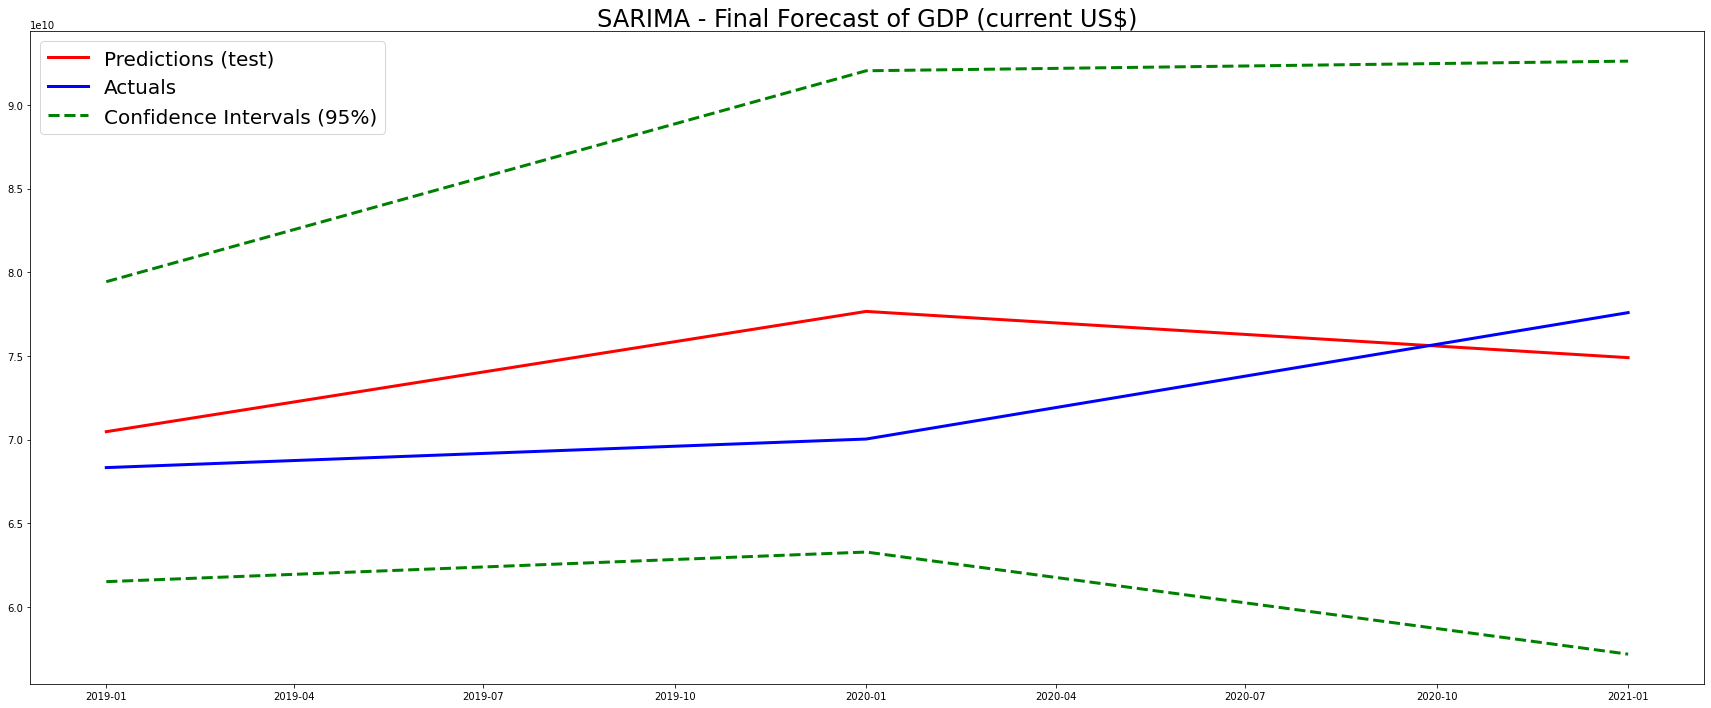

In [36]:
plot_forecast(df_test, full=False)
plt.title("SARIMA - Final Forecast of GDP (current US$)")
plt.show()

# Интерполяция и сэмплирование
## Задание 1
Проверьте данные на наличие пропущенных дат.

In [37]:
df.asfreq("AS")

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


## Задание 2
Проверьте данные на наличие пропущенных значений.

In [38]:
df.isnull().sum()

GDP (current US$)    0
dtype: int64

## Задание 3
Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN.

In [39]:
df["GDP (current US$)"] = df["GDP (current US$)"].apply(
    lambda x: np.nan if x == 0 else x
)

## Задание 4
Для заполнения пропусков выполните интерполяцию с использованием метода `interpolate`.

In [40]:
df = df.interpolate(method="linear")

In [41]:
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [42]:
print(f"{df.shape=:}")

df.shape=(62, 1)


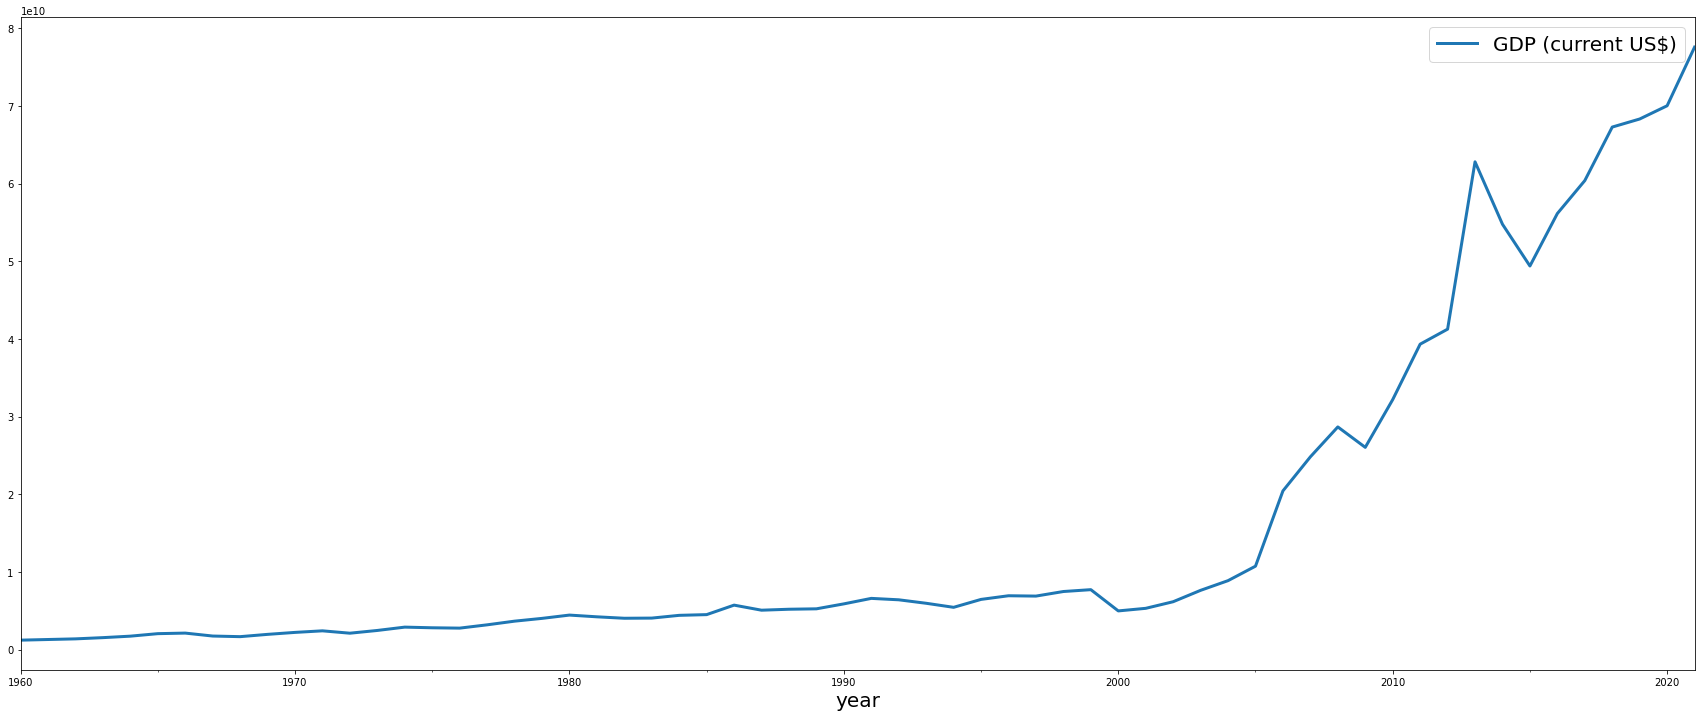

In [43]:
df.plot()
plt.show()

In [44]:
df_train = df.iloc[:-3]
df_test = df.iloc[-3:]

## Задание 6
Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [45]:
is_stationary(df_train["GDP (current US$)"])

adf:  0.8030073326980101
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


False

In [46]:
is_stationary(df_train["GDP (current US$)"].diff())

adf:  -1.825565224643604
p-value:  0.36784515276563223
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


False

In [47]:
is_stationary(df_train["GDP (current US$)"].diff(2))

adf:  -3.9998034409491505
p-value:  0.001411540843666124
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}


True

Первые разности нестационарны, но вторые - стационарны. Тогда d = 2.

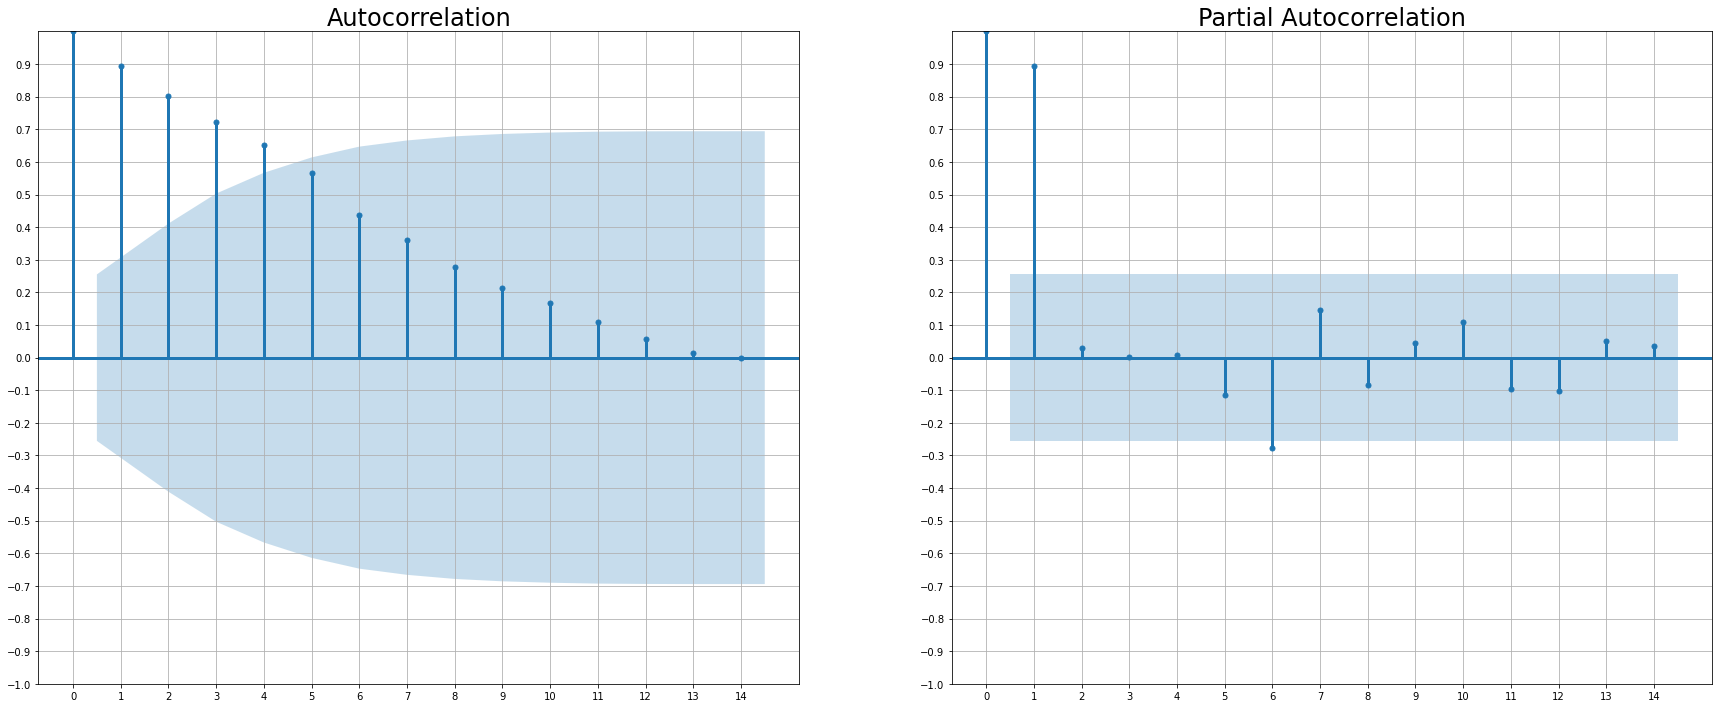

In [48]:
fig, ax = plt.subplots(1, 2)
plot_correlogram(df_train["GDP (current US$)"], plot_acf, ax[0])
plot_correlogram(df_train["GDP (current US$)"], plot_pacf, ax[1])
plt.show()

In [49]:
grid_search = GridSearch(ARIMA, param_grid)

In [50]:
grid_search.fit(df_train["GDP (current US$)"], d=d)

4it [00:00,  6.81it/s]


In [51]:
grid_search.best_params_

(2, 2, 2)

# Задание 5
Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

In [52]:
print(grid_search.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1332.819
Date:                Thu, 26 Jan 2023   AIC                           2675.637
Time:                        22:52:49   BIC                           2685.853
Sample:                    01-01-1960   HQIC                          2679.607
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0456      0.068    -15.387      0.000      -1.179      -0.912
ar.L2         -0.3636      0.090     -4.047      0.000      -0.540      -0.188
ma.L1          0.1477      0.110      1.341      0.1

По сравнению с моделью, обученной на неинтерполированных данных, у новой модели AIC-критерий незначительно упал (на 0.01%). Вывод – интерполяция улучшает качество модели.

In [53]:
df_pred = pd.concat(
    [
        df["GDP (current US$)"],
        grid_search.predict(df),
        grid_search.get_forecast(df_test["GDP (current US$)"]).conf_int(
            alpha=0.05
        ),
    ],
    axis=1,
)

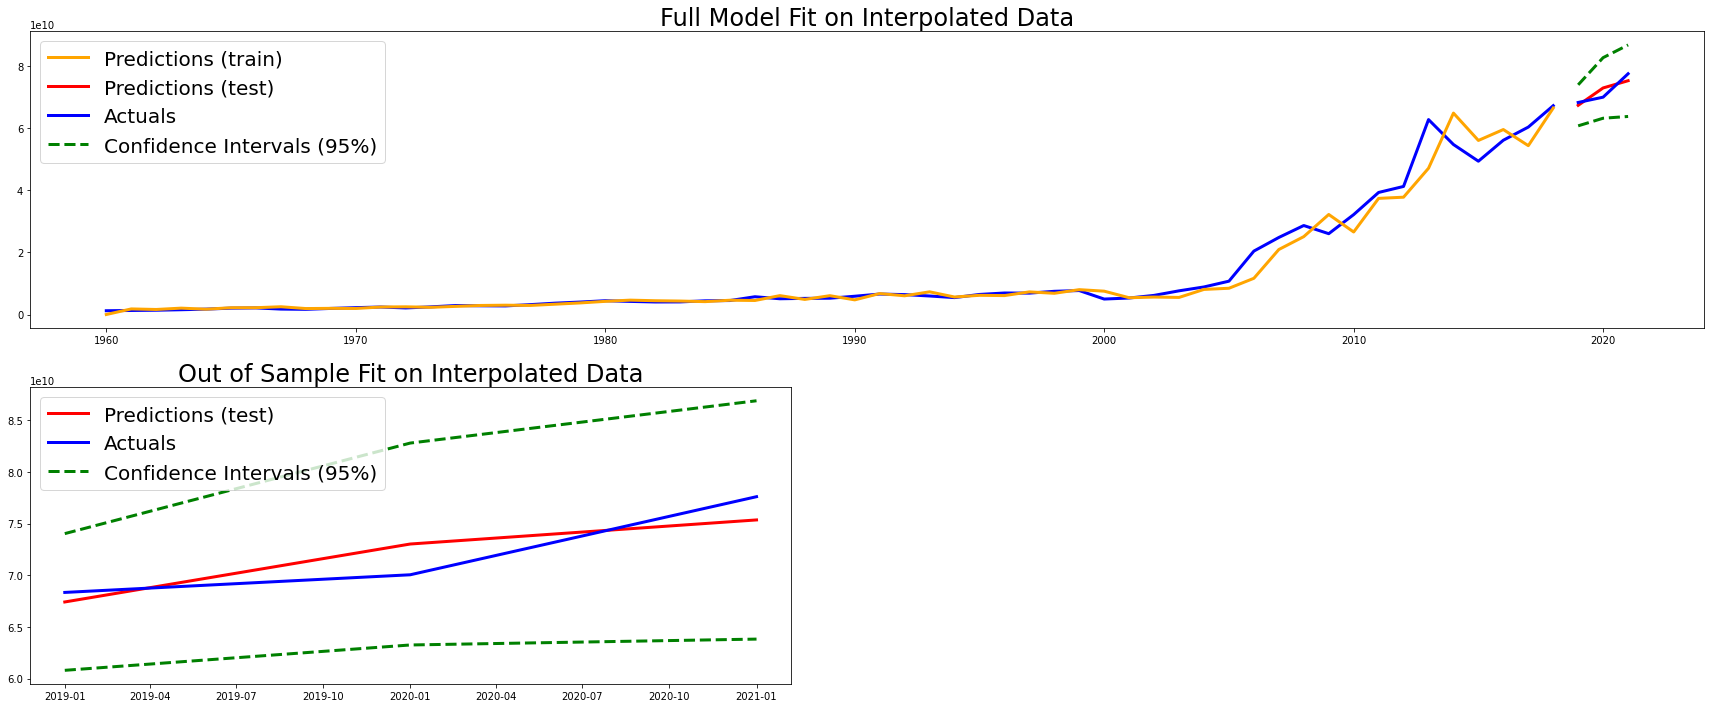

In [54]:
plt.subplot(2, 1, 1)
plot_forecast(df_pred)
plt.title("Full Model Fit on Interpolated Data")

plt.subplot(2, 2, 3)
plot_forecast(df_pred, full=False)
plt.title("Out of Sample Fit on Interpolated Data")

plt.show()

# Модели прогнозирования гетероскедастичности. Валидация временных рядов.
## Задание 1
Посчитайте волатильность для вашего временного ряда.

In [55]:
df["volatility"] = df["GDP (current US$)"].pct_change(1).mul(100).abs()

In [56]:
df["volatility"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: volatility, dtype: float64

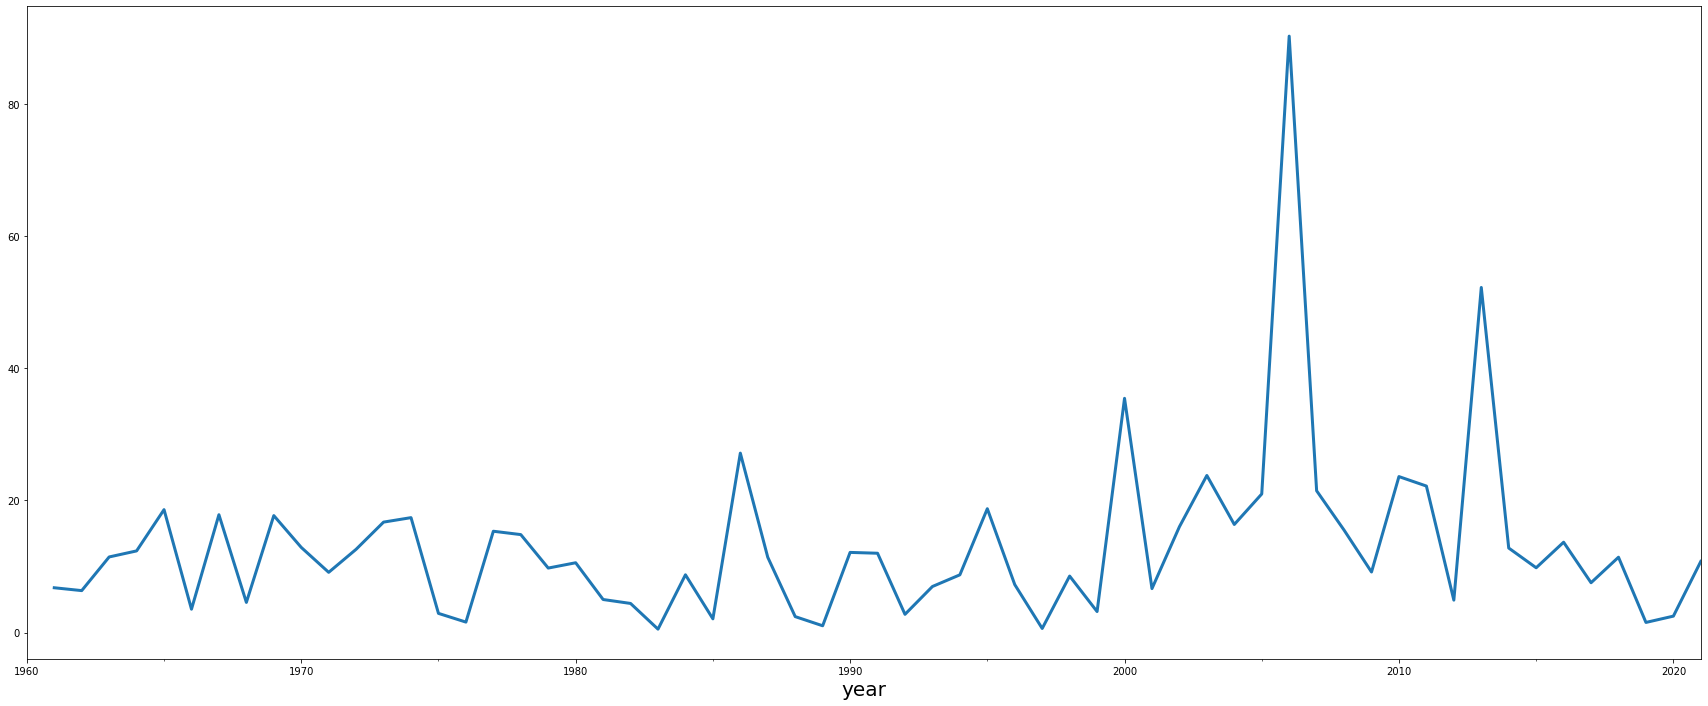

In [57]:
df["volatility"].plot()
plt.show()

In [58]:
df = df.drop(columns="GDP (current US$)")

In [59]:
df_train = df.iloc[:-3]
df_test = df.iloc[-3:]

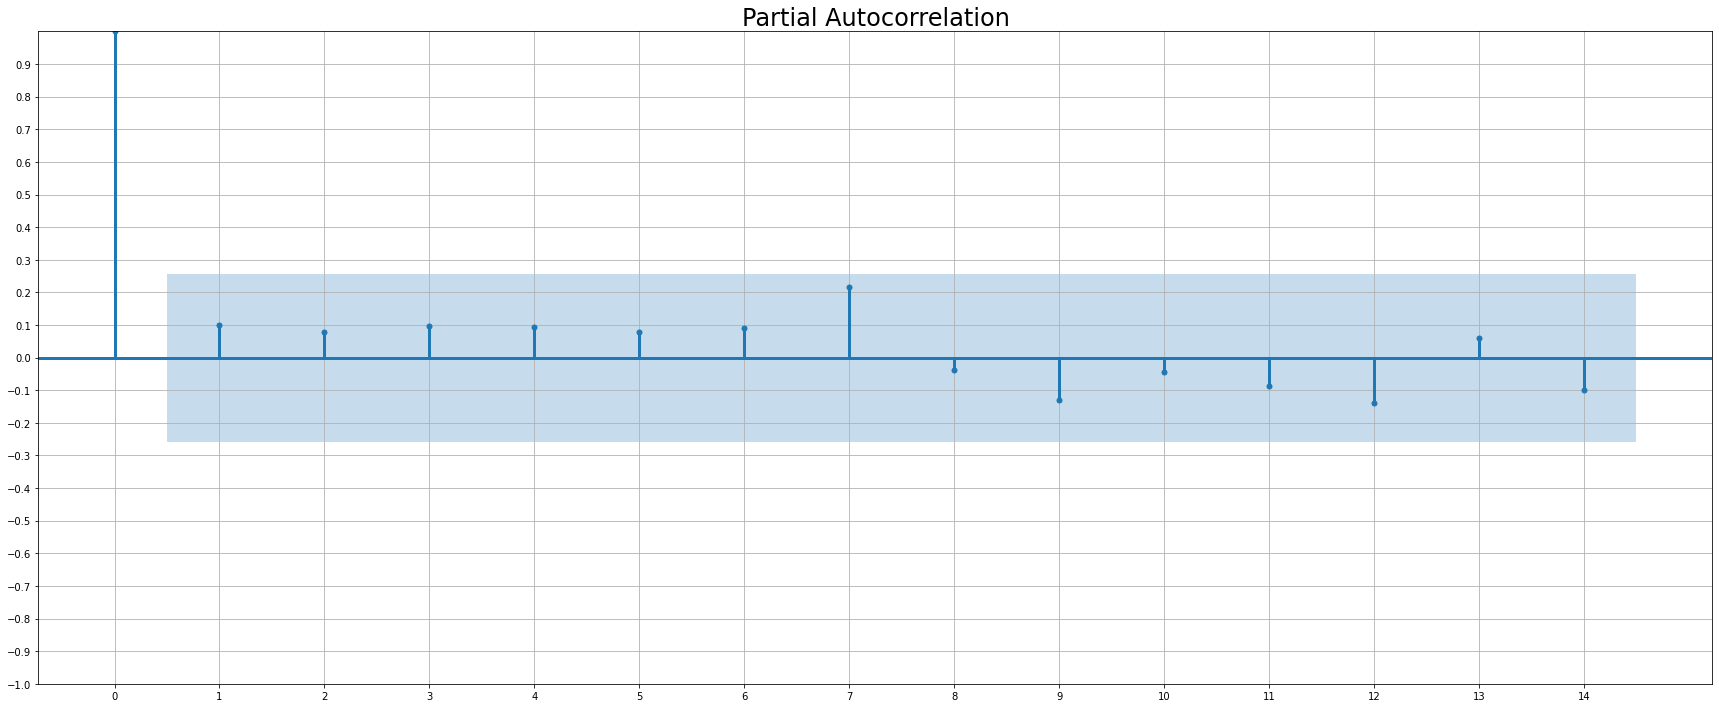

In [60]:
fig, ax = plt.subplots()
plot_correlogram(df_train["volatility"][1:], plot_pacf, ax)
plt.show()

Как мы видим, на графике PACF нет ни одного лага (кроме нулевого), превышающего уровень значимости. Поэтому берём параметры модели p=1, q=1.

In [61]:
is_stationary(df_train["volatility"][1:])

adf:  -6.725311059553778
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}


True

## Задание 2
Используйте GARCH-модель для предсказания волатильности.

In [64]:
model = arch_model(df["volatility"].dropna(), p=2, q=2, vol="GARCH")

In [65]:
model_results = model.fit(last_obs=df_test.index[0], update_freq=5)

Iteration:      5,   Func. Count:     39,   Neg. LLF: 228.6095884373151
Iteration:     10,   Func. Count:     74,   Neg. LLF: 226.7262980616956
Iteration:     15,   Func. Count:    109,   Neg. LLF: 226.6994206641058
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.5978300547896
            Iterations: 19
            Function evaluations: 139
            Gradient evaluations: 19


In [66]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           465.196
Method:            Maximum Likelihood   BIC:                           477.558
                                        No. Observations:                   58
Date:                Thu, Jan 26 2023   Df Residuals:                       57
Time:                        22:55:47   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3129      2.221      5.545  2.946e-08 [  7.960, 16.665]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6689     17.107      0.214      0.830 [-29.860, 37.198]
alpha[1]   1.0875e-10      0.107  1.016e-09      1.000 [ -0.210,  0.210]
alpha[2]   3.6529e-07      0.162  2.254e-06      1.000 [ -0.318,  0.318]
beta[1]        1.0000      1.008      0.992      0.321 [ -0.976,  2.976]
beta[2]    3.1769e-07      0.979  3.246e-07      1.000 [ -1.918,  1.918]
========================================================================

Covariance estimator: robust
"""

In [67]:
df_test["prediction"] = model_results.forecast(
    reindex=True
).residual_variance.loc[df_test.index]

In [68]:
rmse = round(
    mean_squared_error(df_test.iloc[:, 0], df_test.iloc[:, 1], squared=False),
    3,
)

rmse=287.200


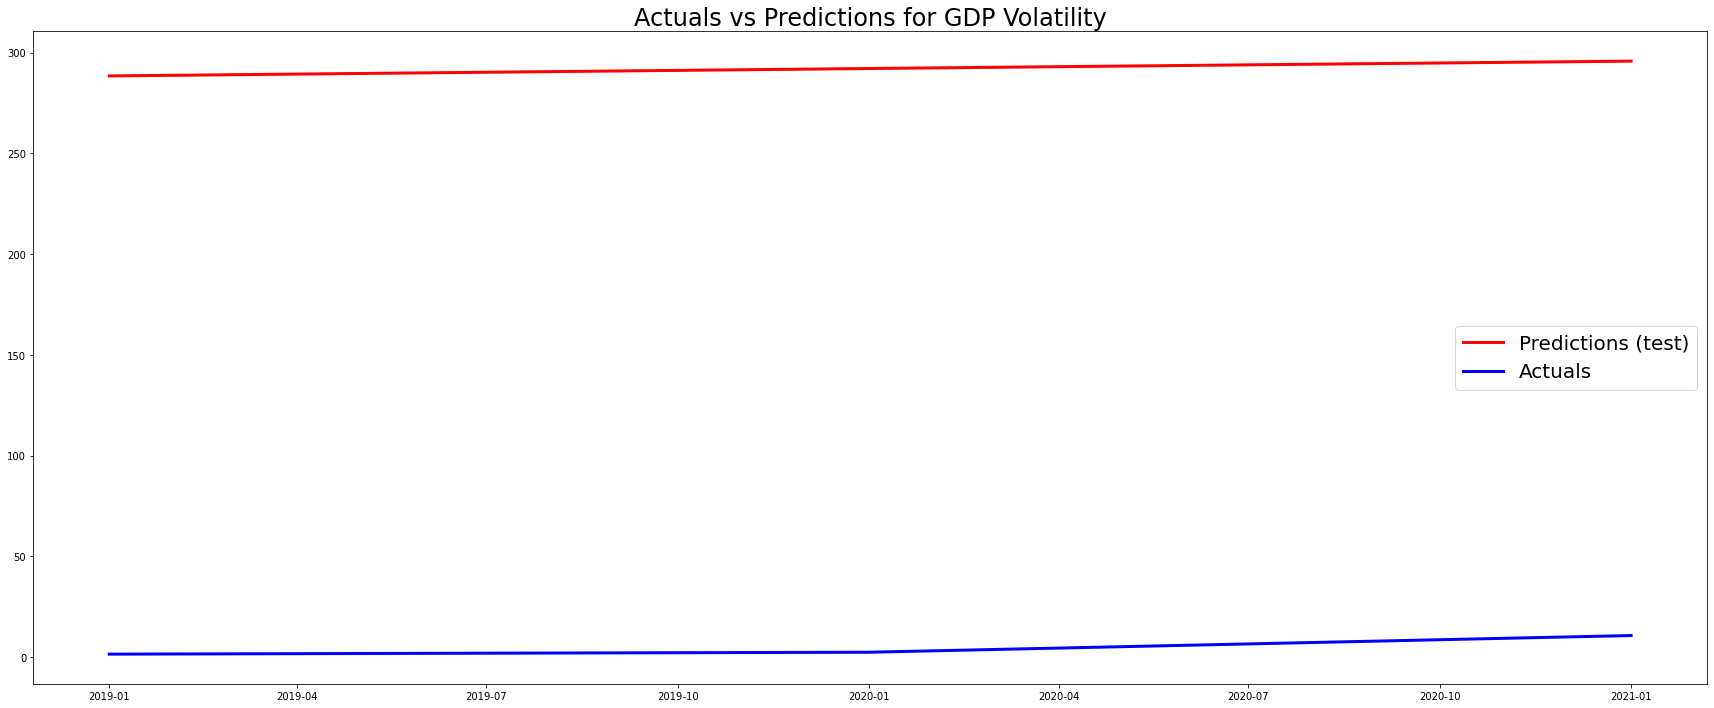

In [69]:
print(f"{rmse=:.3f}")
plot_forecast(df_test, full=False)
plt.title("Actuals vs Predictions for GDP Volatility")
plt.show()

## Задание 3
Используйте линейную регрессию для получения прогноза.

In [70]:
X_train = pd.DataFrame(range(len(df_train)))
X_test = pd.DataFrame(range(len(df)))[-len(df_test) :]
y_train = df_train["volatility"].fillna(0)
y_test = df_test["volatility"]

In [71]:
regr = LinearRegression()

In [72]:
regr.fit(X_train, y_train)

LinearRegression()

In [73]:
df_test["prediction"] = regr.predict(X_test)

## Задание 4
Визуализируйте полученное предсказание вместе с фактическим значением.

In [75]:
rmse = round(
    mean_squared_error(df_test.iloc[:, 0], df_test.iloc[:, 1], squared=False),
    3,
)

rmse=15.856


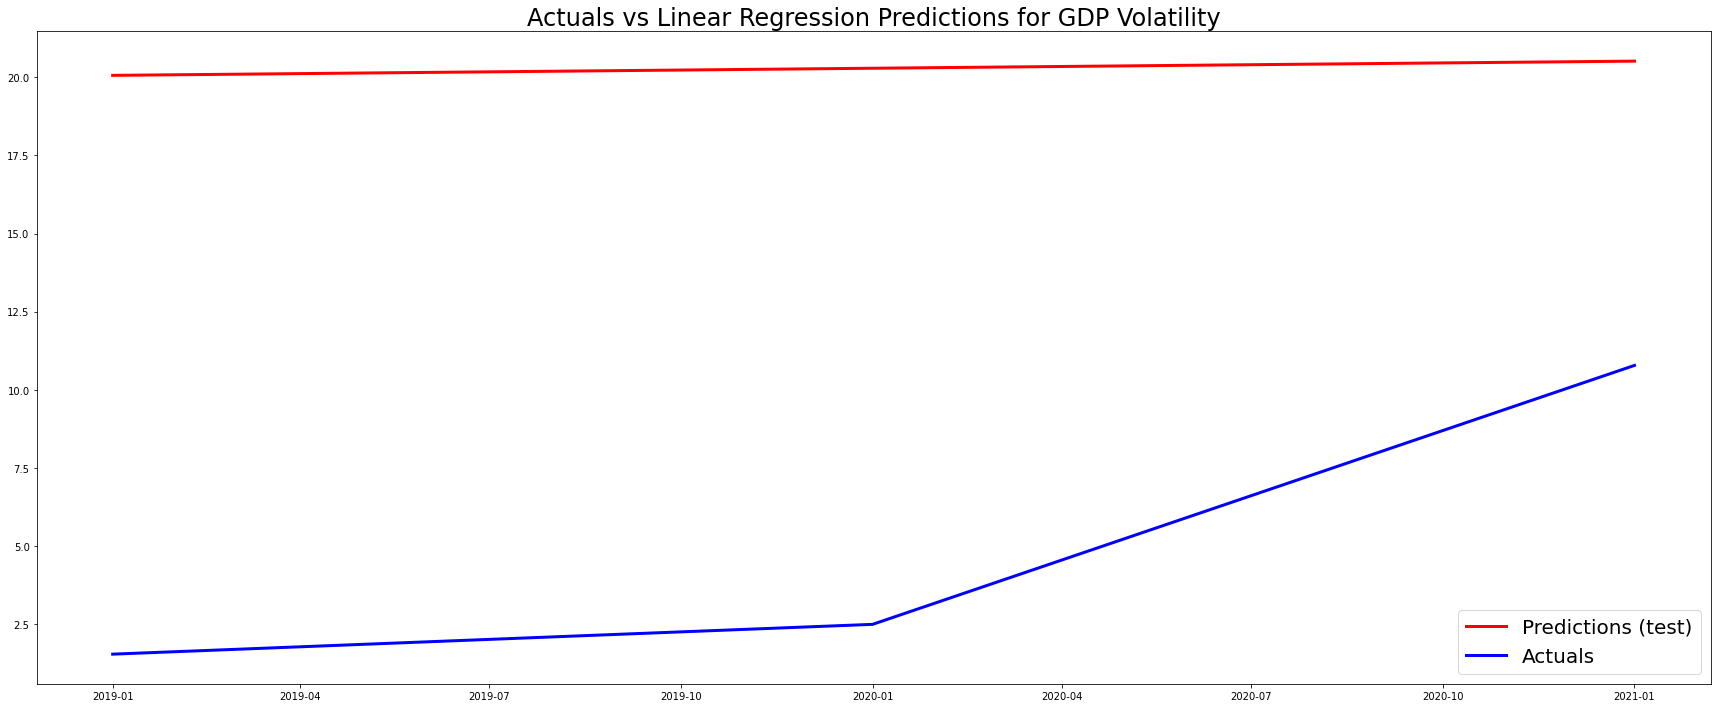

In [76]:
print(f"{rmse=:.3f}")
plot_forecast(df_test, full=False)
plt.title("Actuals vs Linear Regression Predictions for GDP Volatility")
plt.show()